# (Simulation) Earthquake
> Example 1

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연
- categories: [논문연구]

#### 5.1.1 SPECTRAL NETWORK

$$g_{\theta} \star x = U g_{\theta}(\Lambda) U^{\top}x$$

$x$는 실수($n \times 1$ or $1 \times n$), $g_{\theta}$는 $\theta$의 대각행렬, $\theta$는 실수($n \times 1$ or $1 \times n$)

$U$가 정규화된 그래프 라플라시안의 고유벡터 행렬일떄($L = I_N - D^{-\frac{1}{2}}AD^{-\frac{1}{2}} = U\Lambda U^{\top}$), 고유값 $\Lambda$의 대각 행렬을 가진다.

Bruna가 재안한 operation에서 Henaff 는 평활 계수를 가진 파라미터로 차원적이며 집약적인 spectral filters 를 만듦

---

$W$가 $n \times n$  대칭 행렬

$L = I_N - D^{-\frac{1}{2}}WD^{-\frac{1}{2}}$

$D_{ij} = \sum_{ij}W_{ij}$

$U = (u_1, \dots, u_N)$

$X = \mathbb{R}^N$

$x *_Gg = U^{\top} (U_x \odot U)g)$

$\odot$: a point-wise product

$w_g = (w_1, \dots, w_N)$

$x *_Gg := U^{\top} (diag(w_g)U_x)$

---

#### 5.1.2 CHEBNET

$$g_{\theta} \star x \approx  \sum^{K}_{k=0}\theta_k T_k (\tilde{L})x$$

 The Chebyshev polynomials 체비셰프 다항식

$\tilde{L} = \cfrac{2}{\lambda_{max}} L - I_N$

$\lambda_{max}$는 라플라시안 고유값들 중 가장 큰 값

$T_k (x) = 2xT_{k-1}(x) - T_{k-2} (x)$

$T_0 (x) = 1$, $T_1(x) = x$

## imports

In [1]:
import rpy2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import plotly.express as px
import warnings
warnings.simplefilter("ignore", np.ComplexWarning)
from haversine import haversine
from IPython.display import HTML

In [3]:
import rpy2
import rpy2.robjects as ro 
from rpy2.robjects.vectors import FloatVector 
from rpy2.robjects.packages import importr

## EbayesThresh

In [4]:
%load_ext rpy2.ipython

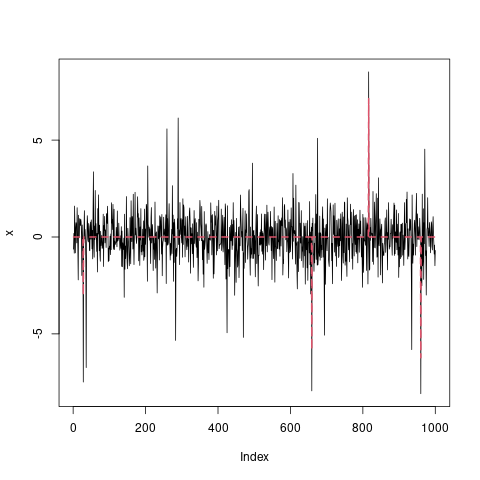

In [89]:
%%R
library(EbayesThresh)
set.seed(1)
x <- rnorm(1000) + sample(c( runif(25,-7,7), rep(0,975)))
plot(x,type='l')
mu <- EbayesThresh::ebayesthresh(x,sdev=2)
lines(mu,col=2,lty=2,lwd=2)

### R + python

`-` R환경에 있던 x를 가지고 오기

In [6]:
%R -o x 

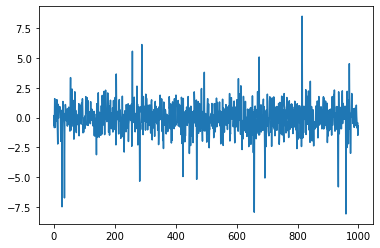

In [7]:
plt.plot(x)

`-` R환경에 있는 ebayesthresh 함수를 가지고 오기

In [8]:
import rpy2.robjects as ro 
from rpy2.robjects.vectors import FloatVector 
from rpy2.robjects.packages import importr

In [9]:
ebayesthresh = importr('EbayesThresh').ebayesthresh

In [10]:
xhat = np.array(ebayesthresh(FloatVector(x)))

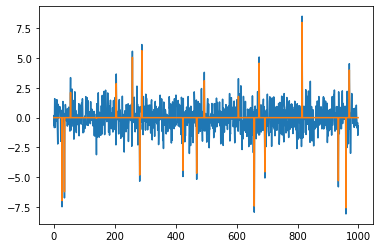

In [11]:
plt.plot(x)
plt.plot(xhat)

## 시도

In [293]:
# _x = np.linspace(0,1,500) + 2*np.random.rand(500) 
# _x.sort()
# _y = 5*_x**2  +x[:500]
# plt.plot(_x,_y,'.')

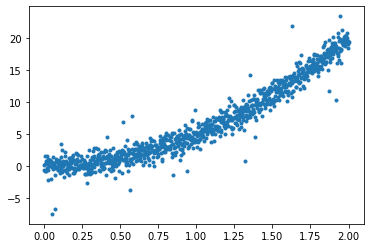

In [297]:
_x = np.linspace(0,2,1000)
_y = 5*_x**2  + x # x is epsilon
plt.plot(_x,_y,'.')

In [298]:
#df = pd.DataFrame(_x,_y).reset_index().rename(columns={'index':'x',0:'y'})

In [299]:
df=pd.DataFrame({'x':_x, 'y':_y})

In [300]:
df

,x,y
0,0.000000,-0.626454
1,0.002002,0.183663
2,0.004004,-0.835548
3,0.006006,1.595461
4,0.008008,0.329828
...,...,...
995,1.991992,19.526868
996,1.993994,18.999390
997,1.995996,19.500713
998,1.997998,18.477228


In [301]:
_matrix1 = np.zeros((1000,1000))
_matrix2 = np.zeros((1000,1000))

In [302]:
_matrix3 = np.zeros((1000,1000))

In [303]:
for i in range(1000):
    for j in range(1000):
        if i==j : 
            _matrix3[i,j] = 0
        
            _matrix3[i,j] = 1

In [304]:
for i in range(1000):
    for j in range(1000):
        if np.abs(i-j) == 1 : 
            _matrix1[i,j] = 1

In [305]:
for i in range(1000):
    for j in range(1000):
        if i==j :
            _matrix2[i,j] = 0
        elif np.abs(i-j) <= 2 : 
            _matrix2[i,j] = 1

In [306]:
# w1 = _matrix + _matrix.T
# w1[0,1]=1
# w1[1,0]=1

In [307]:
w1 = _matrix2

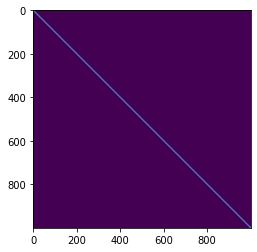

In [308]:
plt.imshow(w1)

In [309]:
# w

In [310]:
# for i in range(1,len(_matrix)-1):
#     for j in range(i+1,i+2): 
#         _matrix[i,j]=1

In [311]:
# w1 = _matrix + _matrix.T
# w1[0,1]=1
# w1[1,0]=1

In [312]:
# w

In [313]:
class SIMUL:
    def __init__(self,df):
        self.df = df 
        self.y = df.y.to_numpy()
        self.x = df.x.to_numpy()
        self.n = len(self.y)
        self.W = w1
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)      
    def fit2(self): # fit with ebayesthresh
        self._eigen()
        self.ybar = self.Psi.T @ self.y # fbar := graph fourier transform of f
        self.power = self.ybar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.ybar**2),sd=2))
        self.ybar_threshed = np.where(self.power_threshed>0,self.ybar,0)
        self.yhat = self.Psi@self.ybar_threshed
        self.df = self.df.assign(yHat = self.yhat)
        self.df = self.df.assign(Residual = self.df.y- self.df.yHat)
        plt.plot(self.x,self.y,'.')
        plt.plot(self.x,self.yhat,'--')

In [314]:
_simul = SIMUL(df)

In [315]:
_simul._eigen()

In [316]:
_simul.L

array([[ 1.        , -0.40824829, -0.35355339, ...,  0.        ,
         0.        ,  0.        ],
       [-0.40824829,  1.        , -0.28867513, ...,  0.        ,
         0.        ,  0.        ],
       [-0.35355339, -0.28867513,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  1.        ,
        -0.28867513, -0.35355339],
       [ 0.        ,  0.        ,  0.        , ..., -0.28867513,
         1.        , -0.40824829],
       [ 0.        ,  0.        ,  0.        , ..., -0.35355339,
        -0.40824829,  1.        ]])

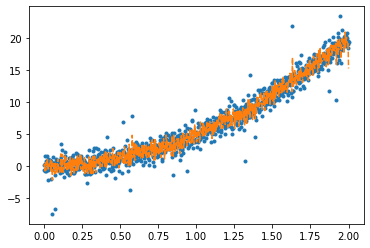

In [317]:
_simul.fit2()

In [276]:
_simul.df

,x,y,yHat,Residual
0,0.000000,-0.626454,0.505072,-1.131526
1,0.001001,0.188648,-0.213245,0.401893
2,0.002002,-0.825619,0.177367,-1.002986
3,0.003003,1.610296,-0.921531,2.531827
4,0.004004,0.349528,0.082951,0.266577
...,...,...,...,...
995,0.995996,4.666687,4.551546,0.115141
996,0.996997,4.104314,4.533026,-0.428712
997,0.997998,4.570703,5.125645,-0.554942
998,0.998999,3.512243,4.368855,-0.856612


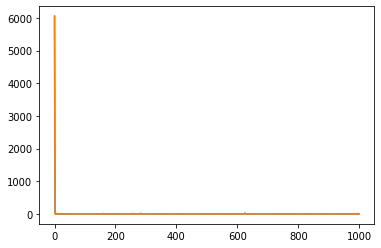

In [277]:
plt.plot(_simul.power)
plt.plot(_simul.power_threshed)

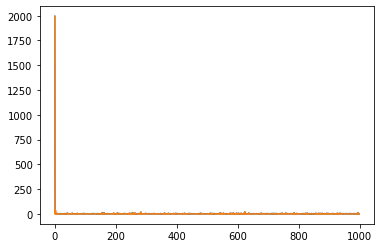

In [278]:
plt.plot(_simul.power[1:])
plt.plot(_simul.power_threshed[1:])

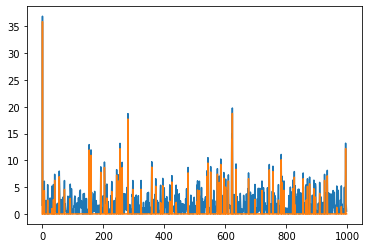

In [279]:
plt.plot(_simul.power[2:])
plt.plot(_simul.power_threshed[2:])

In [280]:
_simul.df

,x,y,yHat,Residual
0,0.000000,-0.626454,0.505072,-1.131526
1,0.001001,0.188648,-0.213245,0.401893
2,0.002002,-0.825619,0.177367,-1.002986
3,0.003003,1.610296,-0.921531,2.531827
4,0.004004,0.349528,0.082951,0.266577
...,...,...,...,...
995,0.995996,4.666687,4.551546,0.115141
996,0.996997,4.104314,4.533026,-0.428712
997,0.997998,4.570703,5.125645,-0.554942
998,0.998999,3.512243,4.368855,-0.856612


In [281]:
_simul.df

,x,y,yHat,Residual
0,0.000000,-0.626454,0.505072,-1.131526
1,0.001001,0.188648,-0.213245,0.401893
2,0.002002,-0.825619,0.177367,-1.002986
3,0.003003,1.610296,-0.921531,2.531827
4,0.004004,0.349528,0.082951,0.266577
...,...,...,...,...
995,0.995996,4.666687,4.551546,0.115141
996,0.996997,4.104314,4.533026,-0.428712
997,0.997998,4.570703,5.125645,-0.554942
998,0.998999,3.512243,4.368855,-0.856612


In [282]:
_simul.df.sort_values('Residual',ascending=False).iloc[:5,:]

,x,y,yHat,Residual
815,0.815816,12.599471,7.397203,5.202268
258,0.258258,6.871286,2.303714,4.567572
674,0.674675,8.466912,4.753498,3.713415
970,0.970971,9.388529,5.699179,3.689350
289,0.289289,7.588433,4.125392,3.463042


In [134]:
_simul.df.sort_values('Residual',ascending=True).iloc[:5,:]

,x,y,yHat,Residual
106,5.249095,0.906477,2.103318,-1.196840
88,3.593178,0.644632,1.610114,-0.965482
254,10.364091,1.933708,2.807225,-0.873516
459,6.142823,1.121410,1.864428,-0.743018
68,1.624593,0.294268,1.036312,-0.742044


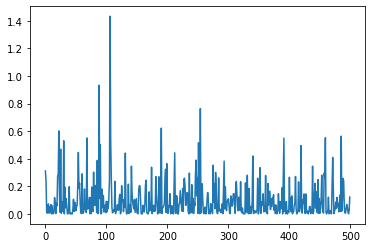

In [135]:
plt.plot((_simul.df.Residual)**2)

---